In [13]:
import numpy as np
import pandas as pd

# Naive Bayes Implementation

In [1]:
class NB_Classifier:
    def fit(self, X, y):
        self.labels_ = np.unique(y)
        self.n_labels_ = len(self.labels_)

        self.n_features_ = X.shape[1]
        self.n_samples_ = X.shape[0]

        self.means_ = np.zeros((self.n_features_, self.n_labels_), dtype=np.float64)
        self.stds_ = np.zeros((self.n_features_, self.n_labels_), dtype=np.float64)
        self.priors_ = np.zeros(self.n_labels_, dtype=np.float64)


        for i, label in enumerate(self.labels_):
            label_data = X[y == label]
            self.means_[:, i] = np.mean(label_data, axis=0)
            self.stds_[:, i] = np.std(label_data, axis=0) + 1e-10
            self.priors_[i] = label_data.shape[0] / self.n_samples_

    def predict(self, X):
        predictions = []

        for i in range(X.shape[0]):
            x = X[i].astype(float)
            likelihoods = self.get_likelihood(x)
            posteriors = likelihoods + np.log(self.priors_)

            predictions.append(self.labels_[np.argmax(posteriors)])

        return np.array(predictions)

    def get_likelihood(self, x):
        likelihoods = np.zeros(self.n_labels_)

        for i in range(self.n_labels_):
            mean = self.means_[:, i]
            std = self.stds_[:, i]

            likelihoods[i] = np.sum(np.log(self.gaussian(x, mean, std) + 1e-10))

        return likelihoods

    def gaussian(self, x, mean, std):
        exponent = np.exp(-0.5 * (((x - mean) / std) ** 2))
        coeff = 1 / (std * ((2 * np.pi) ** (1 / 2)))

        return coeff * exponent

In [3]:
X_tmp = np.array([[1, 2], [1, 4], [2, 3], [6, 8], [7, 9], [8, 8]])
y_tmp = np.array([0, 0, 0, 1, 1, 1])

clf = NB_Classifier()
clf.fit(X_tmp, y_tmp)
print(clf.predict(X_tmp))

[0 0 0 1 1 1]


## Testing Naive Bayes

In [4]:
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

X.shape, y.shape

((150, 4), (150,))

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
clf = NB_Classifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [7]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


# Acquiring Audio Data

In [2]:
import pyaudio
from IPython.display import Audio
from librosa.display import waveshow
import librosa
import matplotlib.pyplot as plt
import tqdm


CHANNELS = 1
RATE = 44100
FRAMES = 1024
FORMAT = pyaudio.paInt16
SECONDS = 5


def record_audio():
    p = pyaudio.PyAudio()

    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=RATE,
        input=True,
        frames_per_buffer=FRAMES,
    )
    frames = []

    num_frames = int(RATE // FRAMES * SECONDS)

    # Initialize progress bar
    with tqdm.tqdm(total=num_frames, desc="Recording", unit="frame", ncols=100) as pbar:
        for i in range(num_frames):
            data = stream.read(FRAMES)
            frames.append(data)
            pbar.update(1)  # Update the progress bar with each frame

    stream.stop_stream()
    stream.close()
    p.terminate()

    return frames


def play_audio(audio_frames):
    audio_np = np.frombuffer(b"".join(audio_frames), dtype=np.int16)
    return Audio(audio_np, rate=RATE)


def plot_wave(audio_frames):
    audio_np = np.frombuffer(b"".join(audio_frames), dtype=np.int16)
    norm_audio_np = librosa.util.normalize(audio_np.astype(np.float32))
    waveshow(norm_audio_np, sr=RATE)

## Recording Audio

In [19]:
audio_frames = record_audio()

Recording: 100%|███████████████████████████████████████████████| 215/215 [00:05<00:00, 42.99frame/s]


In [20]:
play_audio(audio_frames)

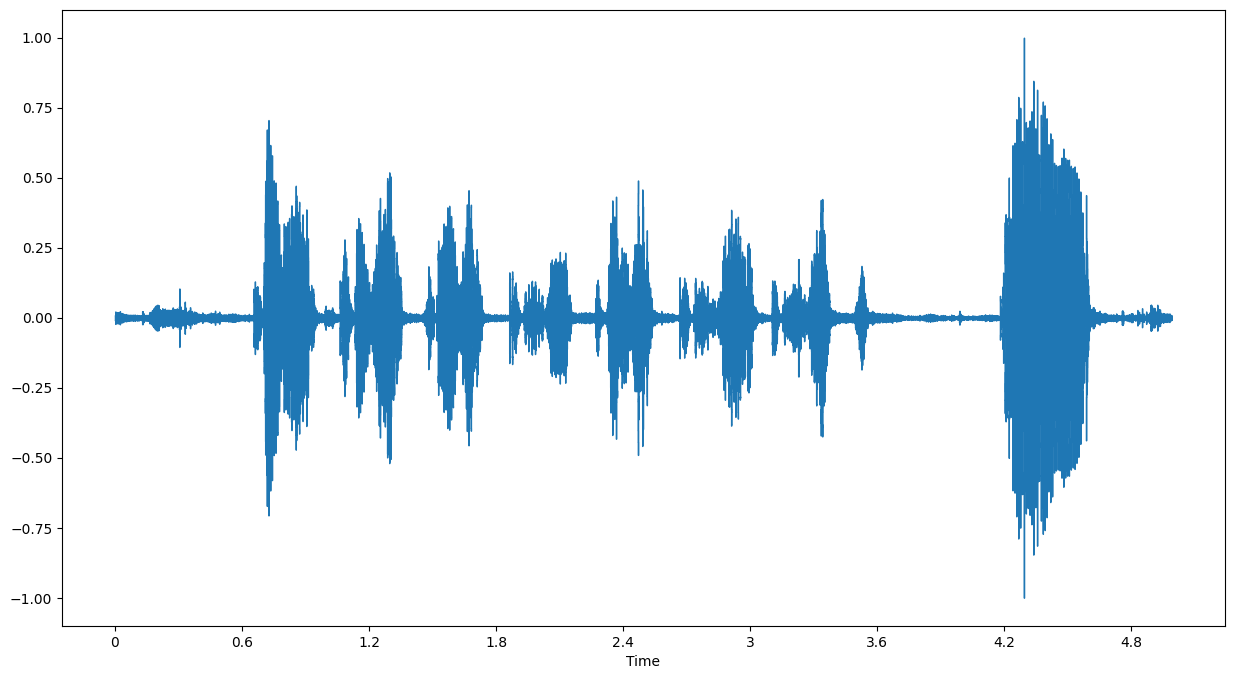

In [13]:
plt.figure(figsize=(15, 8))
plot_wave(audio_frames)
plt.show()

## Noise Reduction

In [3]:
import noisereduce as nr


def reduce_noise(audio_frames):
    audio_np = np.frombuffer(b"".join(audio_frames), dtype=np.int16)
    norm_audio_np = librosa.util.normalize(audio_np.astype(np.float32))
    audio_np_cleaned = nr.reduce_noise(y=norm_audio_np, sr=RATE)

    return audio_np_cleaned

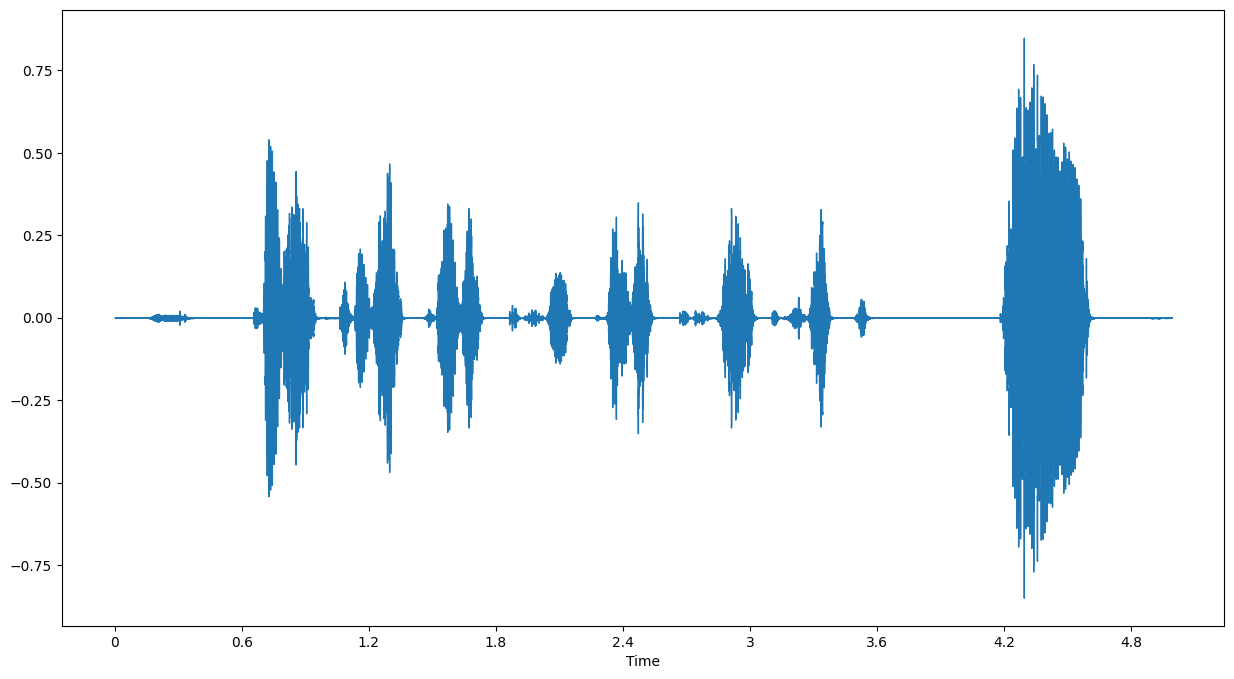

In [15]:
audio_np_cleaned = reduce_noise(audio_frames)


plt.figure(figsize=(15, 8))
waveshow(audio_np_cleaned, sr=RATE)
plt.show()

In [16]:
Audio(audio_np_cleaned, rate=RATE)

## Feature Extraction

### MFCC

In [4]:
def extract_average_mfccs(audio_frames):
    audio_np = np.frombuffer(b"".join(audio_frames), dtype=np.int16)
    norm_audio_np = librosa.util.normalize(audio_np.astype(np.float32))
    mfccs = librosa.feature.mfcc(y=norm_audio_np, sr=RATE, n_mfcc=13)

    return np.mean(mfccs, axis=1)

In [18]:
audio_mfccs = extract_average_mfccs(audio_frames)
audio_mfccs.shape

(13,)

### Spectral Centroid

In [5]:
def extract_average_spectral_centroid(audio_frames):
    audio_np = np.frombuffer(b"".join(audio_frames), dtype=np.int16)
    norm_audio_np = librosa.util.normalize(audio_np.astype(np.float32))
    spectral_centroid = librosa.feature.spectral_centroid(y=norm_audio_np, sr=RATE)

    return np.mean(spectral_centroid, axis=1)

In [20]:
audio_centroids = extract_average_spectral_centroid(audio_frames)
audio_centroids.shape

(1,)

### Spectral Rolloff

In [6]:
def extract_average_spectral_rolloff(audio_frames):
    audio_np = np.frombuffer(b"".join(audio_frames), dtype=np.int16)
    norm_audio_np = librosa.util.normalize(audio_np.astype(np.float32))
    spectral_rolloff = librosa.feature.spectral_rolloff(y=norm_audio_np, sr=RATE)

    return np.mean(spectral_rolloff, axis=1)

In [22]:
audio_rolloffs = extract_average_spectral_rolloff(audio_frames)
audio_rolloffs.shape

(1,)

### Zero-Crossing Rate

In [7]:
def extract_average_zero_crossing_rate(audio_frames):
    audio_np = np.frombuffer(b"".join(audio_frames), dtype=np.int16)
    norm_audio_np = librosa.util.normalize(audio_np.astype(np.float32))
    cross_rate = librosa.feature.zero_crossing_rate(norm_audio_np)

    return np.mean(cross_rate, axis=1)

In [24]:
audio_cross_rate = extract_average_zero_crossing_rate(audio_frames)
audio_cross_rate.shape

(1,)

### Harmonic-to-Noise Ratio

In [8]:
def extract_average_hnr(audio_frames):
    audio_np = np.frombuffer(b"".join(audio_frames), dtype=np.int16)
    norm_audio_np = librosa.util.normalize(audio_np.astype(np.float32))

    audio_harmonic, audio_percussive = librosa.effects.hpss(norm_audio_np)

    harmonic_energy = librosa.feature.rms(y=audio_harmonic)
    percussive_energy = librosa.feature.rms(y=audio_percussive)

    hnr = np.log(harmonic_energy / (percussive_energy + 1e-6))

    return np.mean(hnr, axis=1)

In [26]:
audio_hnr = extract_average_hnr(audio_frames)
audio_hnr.shape

(1,)

## Creating Dataset

This dataset consists of **20 audio recordings** used for a speaker classification task. Each recording has been processed to extract relevant audio features for analysis and machine learning.

- **Total Samples**: 20 audio files
- **Speakers**:
  - **Iyad**: 10 recordings
  - **Remo**: 10 recordings

Audio features that were extracted using `librosa`:
- MFCC (Mel-frequency cepstral coefficients)
- Harmonic-to-Noise Ratio
- Spectral Centroid
- Spectral Rolloff
- Zero-crossing rate

### Notes

- All recordings are of similar duration and were recorded in controlled conditions.
- Labels are balanced (50% for each speaker) for fair model evaluation.
- The difference in microphones will probably affect the model to distinguish between the microphone quality rather than user voice.


In [28]:
def record_n_audios(n):
    audio_list = []
    label_list = []

    for i in range(n):
        user_ended = False
        while True:
            user_input = input(f"Record audio {i + 1} (y/n)? ").strip().lower()
            if user_input == 'y':
                audio_frames = record_audio()
                label_input = input(f"Iyad or Remo? (I/R): ").strip().lower()
                if label_input == 'i':
                    label_list.append('Iyad')
                elif label_input == 'r':
                    label_list.append('Remo')
                elif label_input == 's':
                    label_list.append('Seif')
                
                audio_list.append(audio_frames)
                break
            if user_input == 'n':
                user_ended = True
                break
        if user_ended:
            break
    return audio_list, label_list

In [29]:
num_audios = int(input("Enter the number of audios to record: "))
audios, labels = record_n_audios(num_audios)

np.array(audios).shape, np.array(labels).shape

Recording: 100%|███████████████████████████████████████████████| 215/215 [00:05<00:00, 42.95frame/s]


((15, 215), (15,))

In [30]:
def audios_to_df(audio_list, label_list):
    audio_features = []

    for i, audio in enumerate(audio_list):
        audio_reduced = reduce_noise(audio)
        audio_mfccs = extract_average_mfccs(audio_reduced)
        audio_centroids = extract_average_spectral_centroid(audio_reduced)
        audio_rolloffs = extract_average_spectral_rolloff(audio_reduced)
        audio_cross_rate = extract_average_zero_crossing_rate(audio_reduced)
        audio_hnr = extract_average_hnr(audio_reduced)
        
        features = np.concatenate(
            (audio_mfccs, audio_centroids, audio_rolloffs, audio_cross_rate, audio_hnr), axis=0
        )
        
        features = np.append(features, label_list[i])
        
        audio_features.append(
            pd.Series(features)
        )
    
    audio_df = pd.DataFrame(audio_features)
    audio_df.columns = ['MFCC_0', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'avg_centroid', 'avg_rolloff', 'avg_cross_rate', 'avg_hnr', 'person']
    
    return audio_df

In [31]:
audio_df = audios_to_df(audios, labels)

audio_df.shape

(15, 18)

In [32]:
audio_df.head()

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,avg_centroid,avg_rolloff,avg_cross_rate,avg_hnr,person
0,101.18449401855469,10.325753211975098,8.873483657836914,2.397996187210083,4.641885280609131,0.16460657119750977,2.477985143661499,-0.6138463616371155,1.5636098384857178,-1.8022640943527222,0.15981194376945496,-2.2227835655212402,0.7280940413475037,11030.904025331014,19564.503144054877,0.4983292955139373,0.23053789138793945,Iyad
1,100.13074493408203,6.3117899894714355,7.187717437744141,2.489683151245117,3.8400206565856934,0.45618608593940735,1.7551485300064087,-1.1565535068511963,0.4644516706466675,-0.6973939538002014,1.0412750244140625,-1.085249423980713,1.1525311470031738,11025.678243955868,19369.178734756097,0.49933137793989546,0.17699433863162994,Iyad
2,99.7904052734375,7.6036529541015625,7.104404926300049,2.0250539779663086,4.768913269042969,-0.02140451967716217,2.005314350128174,-0.6282922029495239,1.9680994749069214,-0.7494012713432312,1.3394391536712646,-1.2145147323608398,1.375426173210144,11025.815798231624,19473.018292682926,0.49870982596544716,0.2273082435131073,Iyad
3,100.52235412597656,10.783907890319824,10.28557014465332,3.872965097427368,5.31989049911499,1.1373335123062134,2.6140055656433105,-0.04300415888428688,2.558838367462158,-0.025979816913604736,1.4917718172073364,-1.8519779443740845,0.16548970341682434,11021.044303695793,19547.371617759145,0.4987948923853078,0.25700971484184265,Iyad
4,102.33853912353516,9.69156551361084,7.9042649269104,1.789370059967041,4.787497043609619,0.1471179723739624,1.780056118965149,-1.7207839488983154,0.5540474653244019,-1.9344295263290405,0.6869316697120667,-1.5367183685302734,1.7447067499160767,11023.293141181435,19534.366663490855,0.4978035850391986,0.18245616555213928,Iyad


In [32]:
remo_df = pd.read_csv('Remo_audios.csv')

full_audio_df = pd.concat([audio_df, remo_df], ignore_index=True)
full_audio_df.shape

(20, 18)

In [33]:
full_audio_df.sample(5)

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,avg_centroid,avg_rolloff,avg_cross_rate,avg_hnr,person
15,99.148109,5.163895,3.949504,0.357384,5.649632,2.425772,3.157289,-0.144222,2.635556,-0.770129,0.884335,-0.062822,2.471754,11030.120642,19487.798923,0.499739,0.231714,Remo
13,98.327583,6.752869,7.130763,2.959868,5.618124,1.665163,3.023157,0.304589,2.982676,0.553717,2.532073,1.001608,2.495808,11036.640838,19500.528773,0.500416,0.279709,Remo
1,99.1564712524414,1.0080605745315552,6.979562282562256,3.806710958480835,2.8147435188293457,4.31626033782959,1.6913148164749146,1.0484858751296997,1.9930065870285034,1.32188081741333,1.7174595594406128,-0.11405444890260696,0.09732204675674438,11023.616060156659,19078.568025914636,0.4988975391986063,0.15177102386951447,Iyad
12,99.278526,7.64761,7.689617,4.298172,7.597433,3.179539,3.909365,1.518703,4.185525,0.262111,1.017361,0.029811,1.890613,11030.346124,19521.436738,0.498419,0.259825,Remo
18,100.514572,8.637753,7.534889,3.820235,7.380185,1.272503,1.677732,0.975412,4.613805,-0.994064,-0.846819,-1.28072,1.411058,11024.785312,19514.684165,0.498204,0.218617,Remo


In [34]:
full_audio_df.to_csv('full_audio_df.csv', index=False)

In [15]:
full_audio_df = pd.read_csv('full_audio_df.csv')
full_audio_df.shape

(20, 18)

# Testing Model on Audio Data

In [35]:
from sklearn.metrics import classification_report

In [37]:
X = audio_df.drop('person', axis=1).astype('float64')
y = audio_df['person']

In [39]:
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.3, random_state=42
)

clf = NB_Classifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.40


In [41]:
audio_df

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,avg_centroid,avg_rolloff,avg_cross_rate,avg_hnr,person
0,101.18449401855469,10.325753211975098,8.873483657836914,2.397996187210083,4.641885280609131,0.16460657119750977,2.477985143661499,-0.6138463616371155,1.5636098384857178,-1.8022640943527222,0.15981194376945496,-2.2227835655212402,0.7280940413475037,11030.904025331014,19564.503144054877,0.4983292955139373,0.23053789138793945,Iyad
1,100.13074493408203,6.3117899894714355,7.187717437744141,2.489683151245117,3.8400206565856934,0.45618608593940735,1.7551485300064087,-1.1565535068511963,0.4644516706466675,-0.6973939538002014,1.0412750244140625,-1.085249423980713,1.1525311470031738,11025.678243955868,19369.178734756097,0.49933137793989546,0.17699433863162994,Iyad
2,99.7904052734375,7.6036529541015625,7.104404926300049,2.0250539779663086,4.768913269042969,-0.02140451967716217,2.005314350128174,-0.6282922029495239,1.9680994749069214,-0.7494012713432312,1.3394391536712646,-1.2145147323608398,1.375426173210144,11025.815798231624,19473.018292682926,0.49870982596544716,0.2273082435131073,Iyad
3,100.52235412597656,10.783907890319824,10.28557014465332,3.872965097427368,5.31989049911499,1.1373335123062134,2.6140055656433105,-0.04300415888428688,2.558838367462158,-0.025979816913604736,1.4917718172073364,-1.8519779443740845,0.16548970341682434,11021.044303695793,19547.371617759145,0.4987948923853078,0.25700971484184265,Iyad
4,102.33853912353516,9.69156551361084,7.9042649269104,1.789370059967041,4.787497043609619,0.1471179723739624,1.780056118965149,-1.7207839488983154,0.5540474653244019,-1.9344295263290405,0.6869316697120667,-1.5367183685302734,1.7447067499160767,11023.293141181435,19534.366663490855,0.4978035850391986,0.18245616555213928,Iyad
5,100.4666976928711,8.244855880737305,8.62576675415039,3.381227731704712,4.638864517211914,1.2175097465515137,2.1796138286590576,-0.12335970997810364,0.9925389885902405,-1.400420069694519,0.2733590304851532,-2.1501731872558594,0.2607755661010742,11014.56247101213,19421.598704268294,0.49693931021341464,0.17636026442050934,Remo
6,100.59246063232422,8.595705032348633,8.772232055664062,4.206345081329346,5.909343719482422,0.8524789214134216,2.108356475830078,-0.33194637298583984,1.3369052410125732,-1.8110753297805786,0.13698425889015198,-1.5296516418457031,0.44757646322250366,11035.402911059165,19488.124047256097,0.49996597343205573,0.17404064536094666,Remo
7,100.70854187011719,8.993791580200195,8.70841121673584,2.948812484741211,4.669078350067139,0.9924734830856323,2.1999425888061523,-0.5747890472412109,1.357214331626892,-0.7845987677574158,0.638759195804596,-2.1886799335479736,0.4222520589828491,11022.978761045213,19478.120236280487,0.4997243847996516,0.195084348320961,Remo
8,100.09351348876953,7.456413269042969,7.52522087097168,3.0873405933380127,5.575594425201416,0.9314031600952148,1.0098949670791626,-0.859656572341919,2.248401641845703,-0.29011622071266174,0.8090366721153259,-1.4173262119293213,0.85104900598526,11025.660714673984,19452.685546875,0.49872967479674796,0.15086986124515533,Remo
9,100.10871887207031,8.111218452453613,8.415398597717285,3.0914151668548584,4.811717510223389,0.3553720712661743,1.4396874904632568,-0.6541287302970886,1.4375783205032349,-1.3033864498138428,0.5466494560241699,-2.026137113571167,0.9117922186851501,11028.01601026603,19468.891720655487,0.49774687409262486,0.22664646804332733,Remo


In [40]:
print(classification_report(y_test, y_pred, target_names=clf.labels_))

              precision    recall  f1-score   support

        Iyad       0.25      1.00      0.40         1
        Remo       0.00      0.00      0.00         2
        Seif       1.00      0.50      0.67         2

    accuracy                           0.40         5
   macro avg       0.42      0.50      0.36         5
weighted avg       0.45      0.40      0.35         5



c:\Users\iyadm\OneDrive\Desktop\Supervised Learning Assignments\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\iyadm\OneDrive\Desktop\Supervised Learning Assignments\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\iyadm\OneDrive\Desktop\Supervised Learning Assignments\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

# Bagging Implementation

In [11]:
class My_Bagging():
    def __init__(self, model, n_estimators=10):
        self.model = model
        self.n_estimators = n_estimators
    
    
    def fit(self, X, y):
        self.model_list = []
        indices = np.arange(len(X))
    
        for _ in range(self.n_estimators):
            bootstrap_indices = np.random.choice(indices, size=len(X), replace=True)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]
            
            one_model = self.model.__class__()
            one_model.fit(X_bootstrap, y_bootstrap)
            self.model_list.append(one_model)
            
    def predict(self, X):
        model_predictions = []
        for model in self.model_list:
            y_pred = model.predict(X)
            model_predictions.append(y_pred)

        final_predictions = pd.DataFrame(model_predictions).mode(axis=0).values[0].tolist()
            
        return np.array(final_predictions)

## NB Bagging

In [54]:
clf = NB_Classifier()
bag_clf = My_Bagging(clf, n_estimators=10)
bag_clf.fit(X_train, y_train)

In [55]:
y_pred = bag_clf.predict(X_test)
y_pred

array(['Iyad', 'Remo', 'Remo', 'Iyad', 'Iyad', 'Iyad'], dtype='<U4')

In [56]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


## Logistic Regression Bagging

In [57]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
bag_clf = My_Bagging(clf, n_estimators=10)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


# Model Comparison

In [58]:
models = {
    "Naive Bayes": NB_Classifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Bagged NB (10)": My_Bagging(NB_Classifier(), n_estimators=10),
    "Bagged LR (10)": My_Bagging(LogisticRegression(max_iter=1000), n_estimators=10)
}

In [59]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=np.unique(y), output_dict=True)
    return acc, report

In [60]:
results = []
for name, model in models.items():
    acc, report = evaluate_model(model, X_train, y_train, X_test, y_test)
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision (Iyad)': report['Iyad']['precision'],
        'Recall (Iyad)': report['Iyad']['recall'],
        'F1 (Iyad)': report['Iyad']['f1-score'],
        'Precision (Remo)': report['Remo']['precision'],
        'Recall (Remo)': report['Remo']['recall'],
        'F1 (Remo)': report['Remo']['f1-score']
    })

In [61]:
results_df = pd.DataFrame(results)
print("\nPerformance Comparison:")
print(results_df.to_string(index=False))


Performance Comparison:
              Model  Accuracy  Precision (Iyad)  Recall (Iyad)  F1 (Iyad)  Precision (Remo)  Recall (Remo)  F1 (Remo)
        Naive Bayes       1.0               1.0            1.0        1.0               1.0            1.0        1.0
Logistic Regression       1.0               1.0            1.0        1.0               1.0            1.0        1.0
     Bagged NB (10)       1.0               1.0            1.0        1.0               1.0            1.0        1.0
     Bagged LR (10)       1.0               1.0            1.0        1.0               1.0            1.0        1.0


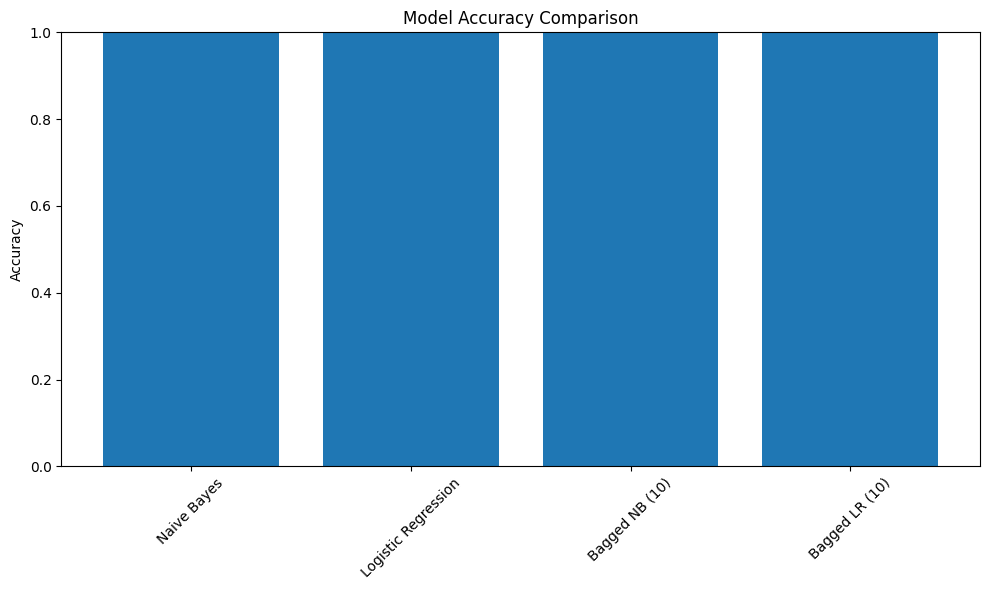

In [62]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Accuracy'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

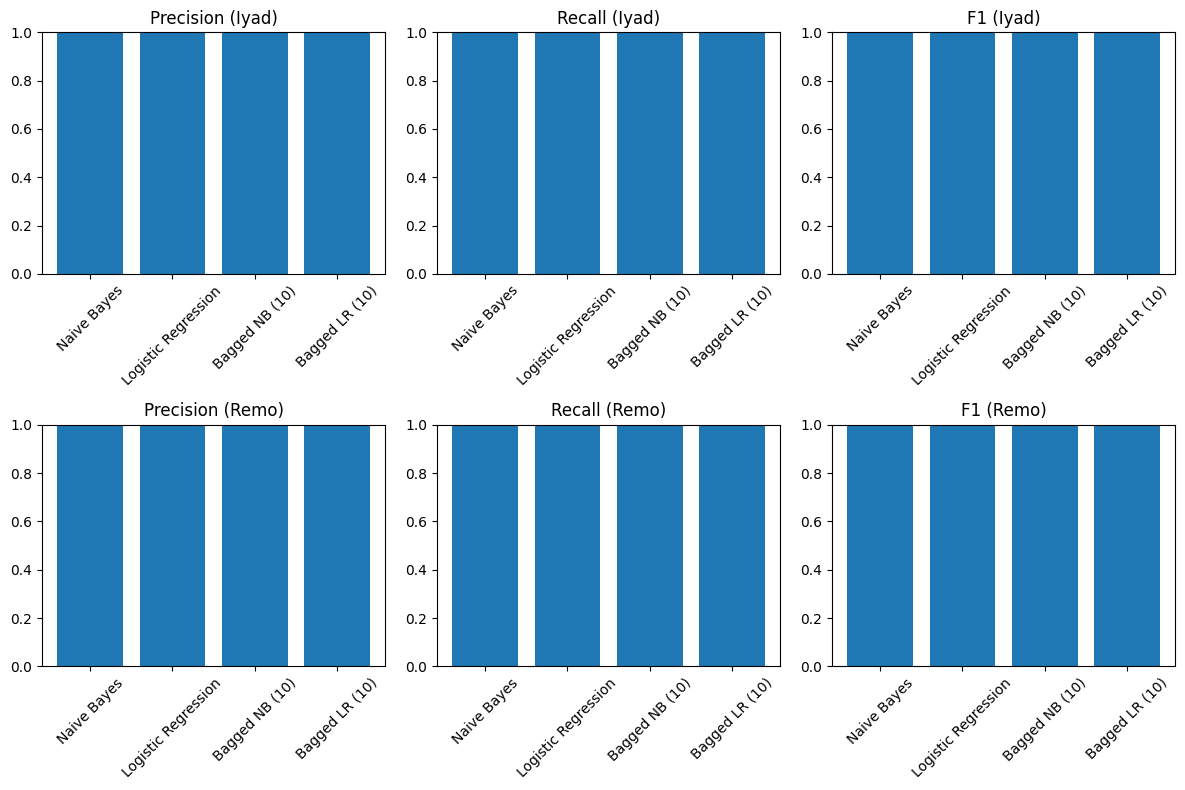

In [63]:
metrics = ['Precision (Iyad)', 'Recall (Iyad)', 'F1 (Iyad)', 
           'Precision (Remo)', 'Recall (Remo)', 'F1 (Remo)']

plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plt.bar(results_df['Model'], results_df[metric])
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

The perfect test scores implies easy distinguishability between the two classes, likely because of the difference in the quality of the microphones used to record each of the speakers's voices.

# Live Prediction

In [42]:
X = full_audio_df.drop('person', axis=1)
y = full_audio_df['person']

clf = NB_Classifier()
full_model = My_Bagging(clf, n_estimators=10)
full_model.fit(X.values, y.values)

In [44]:
def record_and_predict(model):
    audio_frames = record_audio()
    test = audios_to_df([audio_frames], ['test']).drop('person', axis=1).astype('float64')
    return model.predict(test.values)

record_and_predict(full_model)

Recording: 100%|███████████████████████████████████████████████| 215/215 [00:05<00:00, 42.96frame/s]


array(['Iyad'], dtype='<U4')